# Import packages

In [1]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import time
from bs4 import BeautifulSoup
import pandas as pd
import re
from datetime import date
from datetime import datetime
from random import randrange
import glob
import os
from tqdm import tqdm_notebook
from tqdm import tqdm
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import geocoder
import plotly.express as px
import numpy as np
import mpu
import warnings
from scipy import stats

from bokeh.models import *
from bokeh.plotting import *
from bokeh.io import *
from bokeh.tile_providers import *
from bokeh.palettes import *
from bokeh.transform import *
from bokeh.layouts import *

%matplotlib inline
pd.set_option('display.max_columns', None)

# Read in apartment data

In [2]:
folder_name = '../all_apartments_211221'

In [3]:
# setting the path for joining multiple files
files = os.path.join(folder_name, '*.csv')
# list of merged files returned
files_to_join = glob.glob(files)

In [4]:
len(files_to_join)

31225

In [5]:
def read_in_apartment_data(apt_folder_name = '../all_apartments_211221',
                           base_file = '../base_data20211221_035607.csv',
                           print_duplicate_check = True, save_csv = True):
    
    # Setting the path for joining multiple files
    files = os.path.join(apt_folder_name, '*.csv')
    # List of merged files returned
    files_to_join = glob.glob(files)
    
    apt_data = pd.read_csv(files_to_join[0])
    i = 1
    
    for filename in tqdm(files_to_join[1:], desc = "Progress (read in this many files)"):   
        try:
            new_file_to_add = pd.read_csv(filename)
            apt_data = pd.concat([apt_data, new_file_to_add], ignore_index=True)
        except:
            continue
    
    if print_duplicate_check:
        print("Data row number before duplicate check:")
        print(len(apt_data))
    
    apt_data = apt_data.drop_duplicates(subset=apt_data.columns.difference(['download_time']))
    
    if print_duplicate_check:
        print("Data row number after duplicate check:")
        print(len(apt_data))
    
    # Read in base data  
    base_data = pd.read_csv(base_file)
    
    # Merge apartment scraped data with the base data. 
    # We need to do this because the price and some other metrics are comming from the other table.
    data = pd.merge(apt_data, base_data, left_on= ['link'], right_on=['webpage_all'], how = 'left')
    
    # Drop na
    data = data[data['link'].notna()]
    
    # Rename some variables
    data['Építéséve'] = data['Építéséve'].fillna('nincsmegadva')
    
    if save_csv:
        now = datetime.now()
        dt_string = now.strftime("%Y%m%d_%H%M%S")
        apt_data_filename = '../combined_apt_data_' + str(dt_string) + '.csv'
        data.to_csv(apt_data_filename, encoding='utf-8', index=False)
    
    return(data)

In [6]:
#all_apt = read_in_apartment_data()

In [7]:
all_apt = pd.read_csv('../combined_apt_data_211222.csv')
#all_apt

Look at how our data looks like:

Print out one link. This is important to us, since it contains information. Such as district and the type of apartament. We need to create variables using them

In [8]:
random_number = randrange(len(all_apt))
print(random_number)
one_link = all_apt['link'][random_number]
print(one_link)

28681
https://ingatlan.com/xx-ker/elado+lakas/tegla-epitesu-lakas/31861396


In [9]:
all_apt

,Ingatlanállapota,Építéséve,Komfort,Energiatanúsítvány,Emelet,Épületszintjei,Lift,Belmagasság,Fűtés,Légkondicionáló,Rezsiköltség,Akadálymentesített,FürdőésWC,Tájolás,Kilátás,Erkélymérete,Kertkapcsolatos,Tetőtér,Parkolás,Parkolóhelyára,link,error,download_time,Panelprogram,links,prices,adresses,area_sizes,room_numbers,balcony_sizes,webpage_all
0,újépítésű,2021,összkomfortos,BB,6,7,van,3mnélalacsonyabb,házközpontiegyedimérésselgázkazán,van,nincsmegadva,igen,egyhelyiségben,nyugat,kertrenéz,1293m²,nem,nemtetőtéri,teremgarázshelymegvásárolható,4500000Ft,https://ingatlan.com/xi-ker/elado+lakas/tegla-...,no,2021.12.21 04:50:00,NaN,/xi-ker/elado+lakas/tegla-epitesu-lakas/31973403,53.75 M Ft,"Budafoki út 215, XI. kerület",41 m² terület,2 szoba,12.93 m² erkély,https://ingatlan.com/xi-ker/elado+lakas/tegla-...
1,újépítésű,2020,összkomfortos,nincsmegadva,1,5,van,3mnélalacsonyabb,házközpontiegyediméréssel,nincs,nincsmegadva,igen,nincsmegadva,délkelet,nincsmegadva,2342m²,nincsmegadva,nincsmegadva,teremgarázshelymegvásárolható,4700000Ft,https://ingatlan.com/xi-ker/elado+lakas/tegla-...,no,2021.12.21 04:50:04,NaN,/xi-ker/elado+lakas/tegla-epitesu-lakas/30457153,102.9 M Ft,"Rétköz utca, XI. kerület",94 m² terület,4 szoba,23.42 m² erkély,https://ingatlan.com/xi-ker/elado+lakas/tegla-...
2,újépítésű,2024,összkomfortos,BB,1,többmint10,van,3mnélalacsonyabb,gázkazánhőszivattyú,van,nincsmegadva,igen,egyhelyiségben,kelet,kertrenéz,857m²,nem,nemtetőtéri,teremgarázshelymegvásárolható,5000000Ft,https://ingatlan.com/xi-ker/elado+lakas/tegla-...,no,2021.12.21 04:50:07,NaN,/xi-ker/elado+lakas/tegla-epitesu-lakas/32605162,52.06 M Ft,"Szerenád utca 4, XI. kerület",48 m² terület,3 szoba,8.57 m² erkély,https://ingatlan.com/xi-ker/elado+lakas/tegla-...
3,jóállapotú,1950és1980között,összkomfortos,nincsmegadva,8,10,van,3mnélalacsonyabb,távfűtés,nincs,30EFthó,nincsmegadva,különhelyiségben,délnyugat,panorámás,4m²,nem,nemtetőtéri,utcaközterületfizetősövezet,NaN,https://ingatlan.com/xiii-ker/elado+lakas/pane...,no,2021.12.21 04:50:11,nincsmegadva,/xiii-ker/elado+lakas/panel-lakas/32632610,56 M Ft,"Kárpát utca, XIII. kerület",68 m² terület,3 szoba,4 m² erkély,https://ingatlan.com/xiii-ker/elado+lakas/pane...
4,újépítésű,2022,luxus,AA,6,7,van,3mnélalacsonyabb,hőszivattyú,van,nincsmegadva,igen,nincsmegadva,nincsmegadva,nincsmegadva,8m²,nincsmegadva,nincsmegadva,teremgarázshelymegvásárolható,5000000,https://ingatlan.com/xiii-ker/elado+lakas/tegl...,no,2021.12.21 04:50:13,NaN,/xiii-ker/elado+lakas/tegla-epitesu-lakas/3187...,56.49 M Ft,"Lehel utca 9, XIII. kerület",53 m² terület,2 szoba,8 m² erkély,https://ingatlan.com/xiii-ker/elado+lakas/tegl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30239,újszerű,2001és2010között,luxus,nincsmegadva,5,5,van,nincsmegadva,gázcirko,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,panorámás,nincsmegadva,nincsmegadva,nincsmegadva,önállógarázsbennevanazárban,NaN,https://ingatlan.com/v-ker/elado+lakas/tegla-e...,no,2021.12.22 10:30:43,NaN,/v-ker/elado+lakas/tegla-epitesu-lakas/6248324,540 M Ft,"Vörösmarty tér, V. kerület",260 m² terület,3 szoba,NaN,https://ingatlan.com/v-ker/elado+lakas/tegla-e...
30240,felújítandó,nincsmegadva,összkomfortos,nincsmegadva,2,6,van,3mnélmagasabb,gázcirko,van,nincsmegadva,nincsmegadva,különésegybenis,nincsmegadva,panorámás,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,NaN,https://ingatlan.com/v-ker/elado+lakas/tegla-e...,no,2021.12.22 10:30:46,NaN,/v-ker/elado+lakas/tegla-epitesu-lakas/6181917,349 M Ft,"Belgrád rakpart, V. kerület",246 m² terület,5 + 1 fél szoba,NaN,https://ingatlan.com/v-ker/elado+lakas/tegla-e...
30241,jóállapotú,nincsmegadva,összkomfortos,nincsmegadva,2,4,van,3mnélmagasabb,házközponti,van,30EFthó,nincsmegadva,különhelyiségben,nyugat,panorámás,6m²,nincsmegadva,nemtetőtéri,utcaközterületfizetősövezet,NaN,https://ingatlan.com/vii-ker/elado+lakas/tegla...,no,2021.12.22 10:30:49,NaN,/vii-ke

## Create a function that creates some variables and cleans the data

In [10]:
def clean_and_create_variables(data_apt = all_apt,
                              max_price = 500,
                              max_sqrt_price = 2.5,
                              filter_for_multiple_aps = True):
    
    print(len(data_apt))    
    #create district column
    data = data_apt
    data['district'] = data['link'].str.extract("ingatlan.com\/(.*?)\/")
    print(len(data))
    
    data["district"] = data["district"].str.replace("\-ker", "", regex=True)
    print(len(data))
    
    #create type column
    data['apt_type'] = data['link'].str.extract(r'elado\+lakas\/(.*?)\/')
    print(len(data))
    
    #fix price (now I assume all prices are in HUF/Ft)
    data['price_huf'] = data['prices'].replace('\(|[a-zA-Z]+', '', regex=True)
    data['price_huf'] = data['price_huf'].astype(float)
    
    #fix area size
    data['base_area'] = data['area_sizes'].astype(str)
    data['base_area'] = data['base_area'].apply(lambda val: unicodedata.normalize('NFKD', val).encode('ascii', 'ignore').decode())
    data["base_area"] = data["base_area"].str.replace("m2", "", regex=True)
    data['base_area'] = data['base_area'].str.extract('(\d+)', expand=False)
    data['base_area'] = data['base_area'].astype(float)
    data['base_area'] = data['base_area'].fillna(0)
    
    #fix balcony size
    data['balcony_size'] = data['balcony_sizes'].astype(str)
    data['balcony_size'] = data['balcony_size'].apply(lambda val: unicodedata.normalize('NFKD', val).encode('ascii', 'ignore').decode())
    data["balcony_size"] = data["balcony_size"].str.replace("m2", "", regex=True)
    data['balcony_size'] = data['balcony_size'].str.extract('(\d+)', expand=False)
    data['balcony_size'] = data['balcony_size'].astype(float)
    data['balcony_size'] = data['balcony_size'].fillna(0)
    
    #fix room number
    data['room_numbers'] = data['room_numbers'].astype(str)
    data['room_numbers'] = data['room_numbers'].apply(lambda val: unicodedata.normalize('NFKD', val).encode('ascii', 'ignore').decode())
    data["room_numbers"] = data["room_numbers"].str.replace("szoba", "", regex=True)
    data["room_numbers"] = data["room_numbers"].str.replace("fel", "", regex=True)
    data["room_numbers"] = data["room_numbers"].str.replace(" ", "", regex=True)
    
    data['full_room_number'] = data['room_numbers'].str.split('+').str[0]
    data['full_room_number'] = data['full_room_number'].fillna('-1')
    data['full_room_number'] = data['full_room_number'].astype(int)

    data['half_room_number'] = data['room_numbers'].str.split('+').str[1]
    data['half_room_number'] = data['half_room_number'].fillna('0')
    data['half_room_number'] = data['half_room_number'].astype(int)
    
    # max price filter
    data = data[data['price_huf'] <= max_price].reset_index(drop = True)
    print(len(data))
    
    # area + balcony sqm
    data['area_wiht_balcony_sqm'] = data['base_area'] + data['balcony_size'] * 0.5
    
    # sqm price
    data['sqm_price'] = data['price_huf'] / data['area_wiht_balcony_sqm']
    
     # max sqrt price filter
    data = data[data['sqm_price'] <= max_sqrt_price].reset_index(drop = True)
    print(len(data))
    
    # max area price
    data = data[data['base_area']< 500]
    print(len(data))
    
    #Get only one apartment
    data['Építéséve'] = data['Építéséve'].fillna('nincsmegadva')
    data['Tetőtér'] = data['Tetőtér'].fillna('nincsmegadva')
    data['Parkolóhelyára'] = data['Parkolóhelyára'].fillna('nincsmegadva')
    data['Panelprogram'] = data['Parkolóhelyára'].fillna('nincsmegadva')
    data['Energiatanúsítvány'] = data['Parkolóhelyára'].fillna('nincsmegadva')
    data['Parkolóhelyára'] = data['Parkolóhelyára'].fillna('nincsmegadva')
    data['room_numbers'] = data['room_numbers'].fillna('nincsmegadva')
    
    
    if filter_for_multiple_aps:
        # Create filtered_out_data
        keep_only_one = data.groupby(['adresses', 'price_huf', 'base_area', 'balcony_size', 'area_wiht_balcony_sqm', 'sqm_price'], dropna=False).agg(
            quality=('Ingatlanállapota', lambda x:x.value_counts().index[0]),
            year_build = ('Építéséve', lambda x:x.value_counts().index[0]),
            floor = ('Emelet', lambda x:x.value_counts().index[0]),
            max_floor = ('Épületszintjei', lambda x:x.value_counts().index[0]),
            elevator = ('Lift', lambda x:x.value_counts().index[0]),
            indoor_height = ('Belmagasság', lambda x:x.value_counts().index[0]),
            heating = ('Fűtés', lambda x:x.value_counts().index[0]),
            for_handicap = ('Akadálymentesített', lambda x:x.value_counts().index[0]),
            bathroom_and_toilet = ('FürdőésWC', lambda x:x.value_counts().index[0]),
            facing = ('Tájolás', lambda x:x.value_counts().index[0]),
            view = ('Kilátás', lambda x:x.value_counts().index[0]),
            garden = ('Kertkapcsolatos', lambda x:x.value_counts().index[0]),
            top_floor = ('Tetőtér', lambda x:x.value_counts().index[0]),
            parking = ('Parkolás', lambda x:x.value_counts().index[0]),
            parking_place_price = ('Parkolóhelyára', lambda x:x.value_counts().index[0]),
            apt_type = ('apt_type', lambda x:x.value_counts().index[0]),
            energy_label = ('Energiatanúsítvány', lambda x:x.value_counts().index[0]),
            link = ('link', lambda x:x.value_counts().index[0]),
            download_time = ('download_time', lambda x:x.value_counts().index[0]),
            panelprogram = ('Panelprogram', lambda x:x.value_counts().index[0]),
            webpage_all = ('webpage_all', lambda x:x.value_counts().index[0]),
            district = ('district', lambda x:x.value_counts().index[0]),
            full_room_number = ('full_room_number', lambda x:x.value_counts().index[0]),
            half_room_number = ('half_room_number', lambda x:x.value_counts().index[0])
            

        ).reset_index()
        
        print(len(keep_only_one))
    else:
        keep_only_one = data
    
    
    return(data, keep_only_one)

In [11]:
all_apt_cleaned_two = clean_and_create_variables()

30244
30244
30244
30244
30180
30075
30072
23381


In [12]:
all_apt_cleaned = all_apt_cleaned_two[1]
all_apt_cleaned

,adresses,price_huf,base_area,balcony_size,area_wiht_balcony_sqm,sqm_price,quality,year_build,floor,max_floor,elevator,indoor_height,heating,for_handicap,bathroom_and_toilet,facing,view,garden,top_floor,parking,parking_place_price,apt_type,energy_label,link,download_time,panelprogram,webpage_all,district,full_room_number,half_room_number
0,"Abonyi utca 12. mfsz 1., XIV. kerület",42.0,42.0,0.0,42.0,1.000000,felújított,1950előtt,félemelet,3,nincs,3mnélmagasabb,gázcirko,nincsmegadva,egyhelyiségben,északnyugat,kertrenéz,nincsmegadva,nincsmegadva,udvaribeállóbennevanazárban,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,2021.12.22 09:46:44,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,xiv,1,1
1,"Abonyi utca 14, XIV. kerület",41.2,56.0,0.0,56.0,0.735714,jóállapotú,1950előtt,szuterén,földszintes,nincs,3mnélalacsonyabb,gázcirko,nem,különésegybenis,délkelet,kertrenéz,nincsmegadva,nemtetőtéri,utcaközterületfizetősövezet,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,2021.12.21 05:11:58,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,xiv,2,0
2,"Abonyi utca 4., XIV. kerület",49.9,62.0,0.0,62.0,0.804839,felújítandó,1950előtt,2,3,nincsmegadva,3mnélmagasabb,gázkonvektor,nincsmegadva,egyhelyiségben,délkelet,udvari,nem,nincsmegadva,utcaközterületfizetősövezet,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,2021.12.21 13:04:56,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,xiv,2,0
3,"Abonyi utca, XIV. kerület",30.9,42.0,0.0,42.0,0.735714,felújítandó,1950előtt,1,6,van,3mnélmagasabb,házközponti,nem,egyhelyiségben,északnyugat,utcai,nincsmegadva,nincsmegadva,utcaközterületfizetősövezet,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,2021.12.21 10:17:44,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,xiv,1,0
4,"Abonyi utca, XIV. kerület",45.0,67.0,0.0,67.0,0.671642,jóállapotú,1950előtt,félemelet,4,van,3mnélmagasabb,gázkonvektor,nincsmegadva,nincsmegadva,délkelet,kertrenéz,nem,nincsmegadva,udvaribeállóbérelhető,5000Fthó,tegla-epitesu-lakas,5000Fthó,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,2021.12.21 09:46:46,5000Fthó,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,xiv,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23376,"Ősrepülő utca, XVII. kerület",58.6,62.0,24.0,74.0,0.791892,jóállapotú,nincsmegadva,földszint,nincsmegadva,nincsmegadva,3mnélalacsonyabb,gázcirko,nincsmegadva,különhelyiségben,dél,nincsmegadva,igen,nemtetőtéri,udvaribeállóbennevanazárban,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xvii-ker/elado+lakas/tegl...,2021.12.21 21:26:52,nincsmegadva,https://ingatlan.com/xvii-ker/elado+lakas/tegl...,xvii,1,2
23377,"Ősz utca, XX. kerület",18.9,33.0,0.0,33.0,0.572727,jóállapotú,1950előtt,1,2,nincs,3mnélalacsonyabb,gázkonvektor,nem,egyhelyiségben,északkelet,utcai,nem,legfelsőemeletnemtetőtéri,utcaközterületingyenes,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xx-ker/elado+lakas/tegla-...,2021.12.21 17:26:23,nincsmegadva,https://ingatlan.com/xx-ker/elado+lakas/tegla-...,xx,1,0
23378,"Ősz utca, XX. kerület",19.9,37.0,0.0,37.0,0.537838,jóállapotú,nincsmegadva,nincsmegadva,földszintes,nincsmegadva,nincsmegadva,gázkonvektor,nincsmegadva,egyhelyiségben,nincsmegadva,udvari,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xx-ker/elado+lakas/tegla-...,2021.12.22 06:49:17,nincsmegadva,https://ingatlan.com/xx-ker/elado+lakas/tegla-...,xx,1,0
23379,"Ősz utca, XX. kerület",19.9,37.0,20.0,47.0,0.423404,felújított,nincsmegadva,földszint,földszintes,nincs,3mnélalacsonyabb,gázkonvektor,igen,egyhelyiségben,nincsmegadva,kertrenéz,igen,nemtetőtéri,utcaközterületingyenes,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://

## Check some values

In [13]:
count_district = all_apt_cleaned.groupby('district', dropna=False).agg(number_of_obs=('district', 'count'),
                                                                       mean_price = ('price_huf', 'mean'),
                                                                       median_price = ('price_huf', 'median'),
                                                                      mean_sqm = ('area_wiht_balcony_sqm', 'mean'),
                                                                       median_sqm = ('area_wiht_balcony_sqm', 'median'),
                                                                      mean_sqm_price = ('sqm_price', 'mean'),
                                                                      median_sqm_price = ('sqm_price', 'median'))
count_district['mean_price'] = count_district['mean_price'].round(2)
count_district['mean_sqm'] = count_district['mean_sqm'].round(2)
count_district['mean_sqm_price'] = count_district['mean_sqm_price'].round(4)
count_district = count_district.sort_values(by='mean_sqm_price', ascending=False).reset_index()
count_district

,district,number_of_obs,mean_price,median_price,mean_sqm,median_sqm,mean_sqm_price,median_sqm_price
0,v,1211,118.52,97.990,89.64,81.00,1.3007,1.220930
1,i,485,97.70,78.500,83.08,78.00,1.1749,1.015748
2,ii,1005,115.43,85.000,100.06,84.00,1.1319,1.028788
3,xii,677,109.93,75.000,92.09,77.50,1.1232,1.011111
4,xi,1909,83.77,69.400,80.53,71.50,1.0328,1.002417
5,vi,1908,78.62,64.000,77.88,70.00,1.0069,0.949324
6,xiii,2864,70.52,62.800,72.47,66.00,0.9580,0.937129
7,iii,1180,78.42,56.500,86.08,68.00,0.9053,0.855329
8,vii,2489,60.50,52.700,71.68,68.00,0.8592,0.828947
9,ix,1386,61.03,53.995,71.87,65.00,0.8559,0.827747


In [14]:
count_district_only_new = all_apt_cleaned[all_apt_cleaned['quality'] == 'újépítésű'].groupby('district', dropna=False).agg(number_of_obs=('district', 'count'),
                                                                       mean_price = ('price_huf', 'mean'),
                                                                       median_price = ('price_huf', 'median'),
                                                                      mean_sqm = ('area_wiht_balcony_sqm', 'mean'),
                                                                       median_sqm = ('area_wiht_balcony_sqm', 'median'),
                                                                      mean_sqm_price = ('sqm_price', 'mean'),
                                                                      median_sqm_price = ('sqm_price', 'median'))
count_district_only_new['mean_price'] = count_district_only_new['mean_price'].round(2)
count_district_only_new['mean_sqm'] = count_district_only_new['mean_sqm'].round(2)
count_district_only_new['mean_sqm_price'] = count_district_only_new['mean_sqm_price'].round(4)
count_district_only_new = count_district_only_new.sort_values(by='mean_sqm_price', ascending=False).reset_index()
count_district_only_new

,district,number_of_obs,mean_price,median_price,mean_sqm,median_sqm,mean_sqm_price,median_sqm_price
0,i,27,138.80,116.590,75.28,57.00,1.8303,1.900531
1,ii,39,218.89,207.470,125.63,120.00,1.7929,1.791667
2,xii,34,235.85,211.875,135.25,116.00,1.7846,1.747410
3,v,8,142.07,159.500,82.75,78.75,1.7393,1.584148
4,vii,13,63.07,45.000,50.46,38.00,1.3343,1.324815
5,vi,98,87.15,64.465,67.81,54.00,1.2795,1.276693
6,iii,114,105.51,87.435,91.14,84.00,1.1603,1.128751
7,xi,595,83.36,69.500,71.55,64.50,1.1514,1.089308
8,xiii,548,77.58,68.325,73.36,64.25,1.0743,1.054941
9,ix,197,69.34,62.060,65.42,55.00,1.0729,1.042899


In [15]:
count_type = all_apt_cleaned.groupby('apt_type', dropna=False).agg(number_of_obs=('apt_type', 'count'),
                                                                       mean_price = ('price_huf', 'mean'),
                                                                      mean_sqm = ('area_wiht_balcony_sqm', 'mean'),
                                                                      mean_sqm_price = ('sqm_price', 'mean')).reset_index()
count_type['mean_price'] = count_type['mean_price'].round(2)
count_type['mean_sqm'] = count_type['mean_sqm'].round(2)
count_type['mean_sqm_price'] = count_type['mean_sqm_price'].round(4)
count_type = count_type.sort_values(by='mean_sqm_price', ascending=False)
count_type

,apt_type,number_of_obs,mean_price,mean_sqm,mean_sqm_price
2,tegla-epitesu-lakas,21144,71.90,76.03,0.9272
0,csuszozsalus-lakas,479,42.69,58.90,0.7204
1,panel-lakas,1758,37.54,57.92,0.6552


## Check some plots

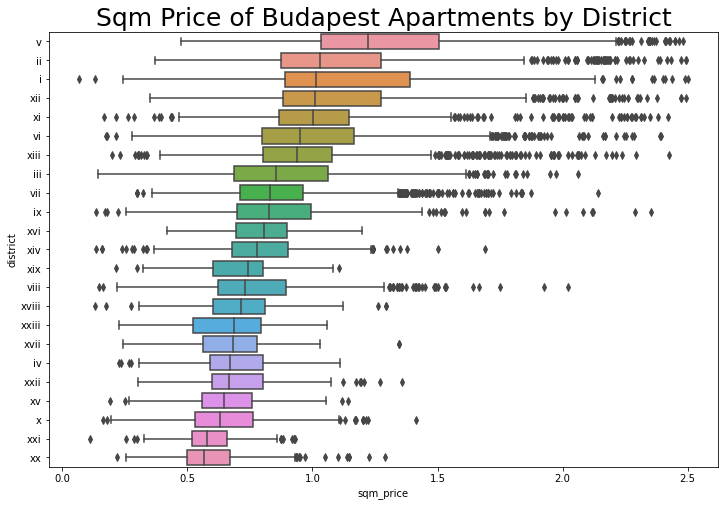

In [16]:
order_of_axis = all_apt_cleaned.groupby('district', dropna=False).agg(number_of_obs=('district', 'count'),
                                                                      mean_sqm_price = ('sqm_price', 'median')).reset_index()
order_of_axis = order_of_axis.sort_values(by='mean_sqm_price', ascending=False)['district']

plt.figure(figsize=(12, 8))
sns.boxplot(y=all_apt_cleaned["district"], x=all_apt_cleaned["sqm_price"],
            order= order_of_axis)
plt.title('Sqm Price of Budapest Apartments by District', size = 25)
plt.show()

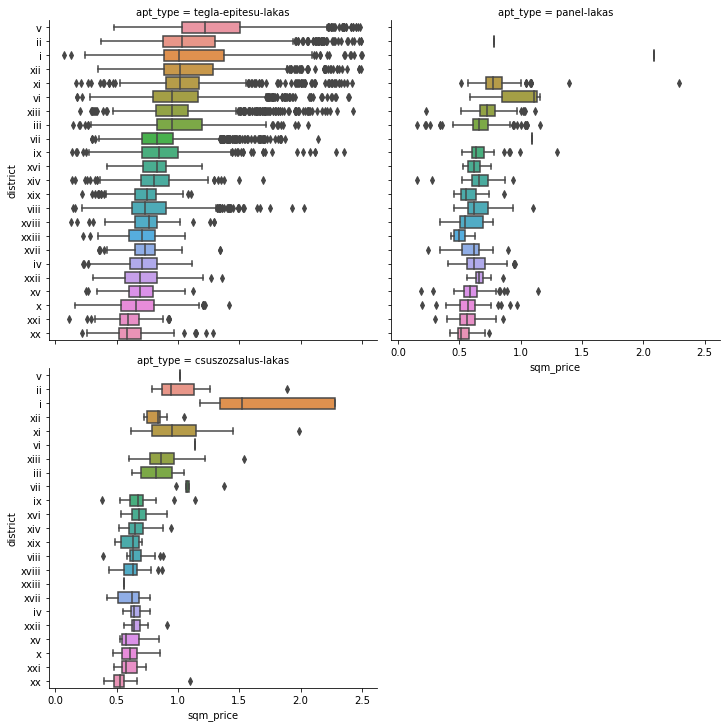

In [17]:
sns.catplot(
    data=all_apt_cleaned, x='sqm_price', y='district',
    col='apt_type', kind='box', col_wrap=2, order=order_of_axis
)
plt.show()

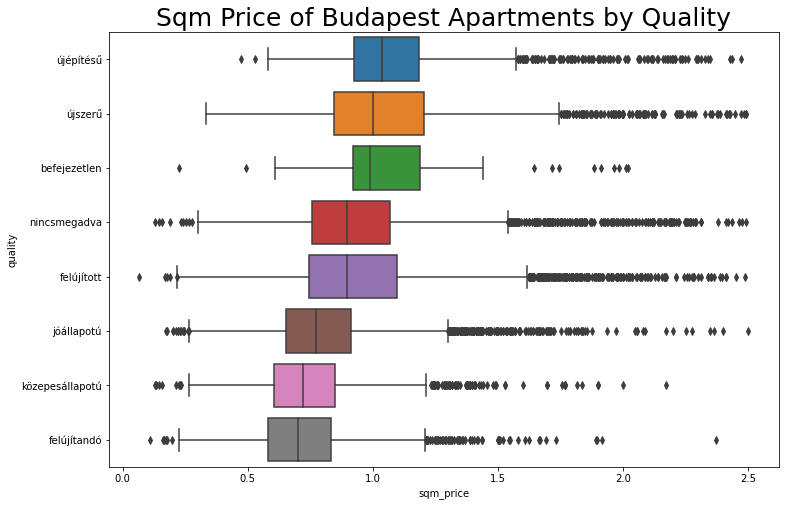

In [18]:
order_of_axis = all_apt_cleaned.groupby('quality', dropna=False).agg(number_of_obs=('quality', 'count'),
                                                                      mean_sqm_price = ('sqm_price', 'median')).reset_index()
order_of_axis = order_of_axis.sort_values(by='mean_sqm_price', ascending=False)['quality']

plt.figure(figsize=(12, 8))
sns.boxplot(y=all_apt_cleaned["quality"], x=all_apt_cleaned["sqm_price"],
            order= order_of_axis)
plt.title('Sqm Price of Budapest Apartments by Quality', size = 25)
plt.show()

## We want to have coordinates too to be able to put our apartments to a map

In [19]:
g = geocoder.osm("Abos utca 23, XII. kerület, Budapest, Hungary")
#g.json

In [20]:
print(g.json['lat'], g.json['lng'], g.json['postal'])

47.499706 19.0115648 1126


In [21]:
def get_coordinates_for_addresses(data = all_apt_cleaned, address_column_name = 'adresses',
                                  limit = 50, save_csv = True):
    
    addresses_data = data.head(limit)
    addresses_data = addresses_data[[address_column_name]]
    addresses_data = addresses_data.drop_duplicates()
    addresses_data['extended_address'] = addresses_data['adresses'] + ", Budapest, Hungary"
    
    address_list = []
    lat_list = []
    lng_list = []
    post_code_list = []

    for address in tqdm(addresses_data['extended_address'], desc = "Progress: "):
        try:
            g = geocoder.osm(address)
            lat_address = g.json['lat']
            lng_address = g.json['lng']
            post_code = g.json['postal']
        except:
            lat_address = float("nan")
            lng_address = float("nan")
            post_code = float("nan")

        lat_list.append(lat_address)
        lng_list.append(lng_address)
        post_code_list.append(post_code)
        address_list.append(address)
    
    addresses_data['lat'] = lat_list
    addresses_data['lat'] = addresses_data['lat'].astype(float)
    
    addresses_data['lng'] = lng_list
    addresses_data['lng'] = addresses_data['lng'].astype(float)
    
    addresses_data['postcode'] = post_code_list
    addresses_data['postcode'] = addresses_data['postcode'].apply(pd.to_numeric, errors='coerce')
    #addresses_data['postcode'] = addresses_data['postcode'].astype(float)
    
    # Drop duplicates
    addresses_data = addresses_data.reset_index(drop = True)   
    
    if save_csv:
        now = datetime.now()
        dt_string = now.strftime("%Y%m%d_%H%M%S")
        addresses_coordinates_data_filename = '../addresses_with_coordinates' + str(dt_string) + '.csv'
        addresses_data.to_csv(addresses_coordinates_data_filename, encoding='utf-8', index=False)
    
    return(addresses_data)

In [22]:
#addresses_dt = get_coordinates_for_addresses(limit=len(all_apt_cleaned))

In [23]:
addresses_dt = pd.read_csv('../addresses_with_coordinates20211224_180554.csv')

In [24]:
## Merging back the coordinates files to the original file
all_apt_cleaned = pd.merge(all_apt_cleaned, addresses_dt, left_on= ['adresses'], right_on=['adresses'], how = 'left')

In [25]:
def create_distances_from_local_points(data_original_coordinates = all_apt_cleaned):
    
    # initialize data
    data = [['korforgalom', 47.49784918136573, 19.040155552114864],
            ['westend', 47.511260986328125, 19.05663299560547],
            ['deakter', 47.4972514, 19.0540535],
            ['varosloget', 47.5148210624106,19.084308817687983],
            ['puskasstadion', 47.50202670121633,19.10539098054504],
            ['boraroster', 47.48010231024167,19.06715340882873],
            ['moricz', 47.47535130259566,19.040599539581294],
            ['mammut', 47.50916777699885,19.026051237884516]]
    
    # Create the pandas DataFrame
    important_locations = pd.DataFrame(data, columns = ['location', 'location_lat', 'location_lng'])
    
    data_for_calculation = data_original_coordinates[['lat', 'lng']]
    data_for_calculation = data_for_calculation.drop_duplicates().reset_index(drop = True)
    
    for i in range(len(important_locations)):
        one_loc_string = important_locations['location'][i]
        one_loc_lat = important_locations['location_lat'][i]
        one_loc_lng = important_locations['location_lng'][i]
        
        colname_to_create = str(one_loc_string) + '_distance'
        
        distance_list = []
        
        for one_calculation in range(len(data_for_calculation)):
            try:
                dist = mpu.haversine_distance((data_for_calculation['lat'][one_calculation], data_for_calculation['lng'][one_calculation]),
                                              (one_loc_lat, one_loc_lng))
                
                dist = round(dist, 1)
                dist = dist * 1000
                dist = int(dist)
            except:
                dist = float("nan")
            distance_list.append(dist)
                
        data_for_calculation[colname_to_create] = distance_list
    
    
    return(data_for_calculation)

In [26]:
distance_data = create_distances_from_local_points()
distance_data

,lat,lng,korforgalom_distance,westend_distance,deakter_distance,varosloget_distance,puskasstadion_distance,boraroster_distance,moricz_distance,mammut_distance
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,47.507331,19.089881,3900.0,2500.0,2900.0,900.0,1300.0,3500.0,5100.0,4800.0
2,47.506101,19.087937,3700.0,2400.0,2700.0,1000.0,1400.0,3300.0,4900.0,4700.0
3,47.499706,19.011565,2200.0,3600.0,3200.0,5700.0,7100.0,4700.0,3500.0,1500.0
4,47.504394,18.987457,4000.0,5300.0,5100.0,7400.0,8900.0,6600.0,5100.0,2900.0
...,...,...,...,...,...,...,...,...,...,...
3855,47.501632,19.111092,5300.0,4200.0,4300.0,2500.0,400.0,4100.0,6000.0,6400.0
3856,47.500737,19.111510,5400.0,4300.0,4300.0,2600.0,500.0,4000.0,6000.0,6500.0
3857,47.470670,19.225553,14300.0,13500.0,13200.0,11700.0,9700.0,12000.0,13900.0,15600.0
3858,47.445107,19.101489,7500.0,8100.0,6800.0,7900.0,6300.0,4700.0,5700.0,9100.0


In [27]:
all_apt_cleaned = pd.merge(all_apt_cleaned, distance_data, left_on= ['lat', 'lng'], right_on=['lat', 'lng'], how = 'left')

In [28]:
all_apt_cleaned

,adresses,price_huf,base_area,balcony_size,area_wiht_balcony_sqm,sqm_price,quality,year_build,floor,max_floor,elevator,indoor_height,heating,for_handicap,bathroom_and_toilet,facing,view,garden,top_floor,parking,parking_place_price,apt_type,energy_label,link,download_time,panelprogram,webpage_all,district,full_room_number,half_room_number,extended_address,lat,lng,postcode,korforgalom_distance,westend_distance,deakter_distance,varosloget_distance,puskasstadion_distance,boraroster_distance,moricz_distance,mammut_distance
0,"Abonyi utca 12. mfsz 1., XIV. kerület",42.0,42.0,0.0,42.0,1.000000,felújított,1950előtt,félemelet,3,nincs,3mnélmagasabb,gázcirko,nincsmegadva,egyhelyiségben,északnyugat,kertrenéz,nincsmegadva,nincsmegadva,udvaribeállóbennevanazárban,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,2021.12.22 09:46:44,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,xiv,1,1,"Abonyi utca 12. mfsz 1., XIV. kerület, Budape...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Abonyi utca 14, XIV. kerület",41.2,56.0,0.0,56.0,0.735714,jóállapotú,1950előtt,szuterén,földszintes,nincs,3mnélalacsonyabb,gázcirko,nem,különésegybenis,délkelet,kertrenéz,nincsmegadva,nemtetőtéri,utcaközterületfizetősövezet,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,2021.12.21 05:11:58,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,xiv,2,0,"Abonyi utca 14, XIV. kerület, Budapest, Hungary",47.507331,19.089881,1146.0,3900.0,2500.0,2900.0,900.0,1300.0,3500.0,5100.0,4800.0
2,"Abonyi utca 4., XIV. kerület",49.9,62.0,0.0,62.0,0.804839,felújítandó,1950előtt,2,3,nincsmegadva,3mnélmagasabb,gázkonvektor,nincsmegadva,egyhelyiségben,délkelet,udvari,nem,nincsmegadva,utcaközterületfizetősövezet,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,2021.12.21 13:04:56,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,xiv,2,0,"Abonyi utca 4., XIV. kerület, Budapest, Hungary",47.506101,19.087937,1146.0,3700.0,2400.0,2700.0,1000.0,1400.0,3300.0,4900.0,4700.0
3,"Abonyi utca, XIV. kerület",30.9,42.0,0.0,42.0,0.735714,felújítandó,1950előtt,1,6,van,3mnélmagasabb,házközponti,nem,egyhelyiségben,északnyugat,utcai,nincsmegadva,nincsmegadva,utcaközterületfizetősövezet,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,2021.12.21 10:17:44,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,xiv,1,0,"Abonyi utca, XIV. kerület, Budapest, Hungary",47.507331,19.089881,1146.0,3900.0,2500.0,2900.0,900.0,1300.0,3500.0,5100.0,4800.0
4,"Abonyi utca, XIV. kerület",45.0,67.0,0.0,67.0,0.671642,jóállapotú,1950előtt,félemelet,4,van,3mnélmagasabb,gázkonvektor,nincsmegadva,nincsmegadva,délkelet,kertrenéz,nem,nincsmegadva,udvaribeállóbérelhető,5000Fthó,tegla-epitesu-lakas,5000Fthó,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,2021.12.21 09:46:46,5000Fthó,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,xiv,2,0,"Abonyi utca, XIV. kerület, Budapest, Hungary",47.507331,19.089881,1146.0,3900.0,2500.0,2900.0,900.0,1300.0,3500.0,5100.0,4800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23376,"Ősrepülő utca, XVII. kerület",58.6,62.0,24.0,74.0,0.791892,jóállapotú,nincsmegadva,földszint,nincsmegadva,nincsmegadva,3mnélalacsonyabb,gázcirko,nincsmegadva,különhelyiségben,dél,nincsmegadva,igen,nemtetőtéri,udvaribeállóbennevanazárban,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xvii-ker/elado+lakas/tegl...,2021.12.21 21:26:52,nincsmegadva,https://ingatlan.com/xvii-ker/elado+lakas/tegl...,xvii,1,2,"Ősrepülő utca, XVII. kerület, Budapest, Hungary",47.470670,19.225553,1174.0,14300.0,13500.0,13200.0,11700.0,9700.0,12000.0,13900.0,15600.0
23377,"Ősz utca, XX. kerület",18.9,33.0,0.0,33.0,0.572727,jóállapotú,1950előtt,1,2,nincs,3mnélalacson

In [29]:
# Add jitter to coordinates
sigma = 0.0003
    
all_apt_cleaned['lat_jitter'] = all_apt_cleaned['lat'].apply(lambda x: np.random.normal(x, sigma, 1)[0])
all_apt_cleaned['lng_jitter'] = all_apt_cleaned['lng'].apply(lambda x: np.random.normal(x, sigma, 1)[0])

# Create mercator coordinates
r_major = 6378137.000
all_apt_cleaned['x'] = r_major * np.radians(all_apt_cleaned['lng_jitter'])
scale = all_apt_cleaned['x'].median()/all_apt_cleaned['lng_jitter'].median()
all_apt_cleaned['y'] = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + all_apt_cleaned['lat_jitter'] * (np.pi/180.0)/2.0)) * scale

In [85]:
# Select tile set to use
chosentile = get_provider(OSM)
# Choose palette
palette = Spectral6
# Tell Bokeh to use df as the source of the data
source = ColumnDataSource(data=all_apt_cleaned[all_apt_cleaned['x'].notna()])
# Define color mapper - which column will define the colour of the data points
color_mapper = linear_cmap(field_name = 'price_huf', palette = palette, low = all_apt_cleaned['price_huf'].min(), high = all_apt_cleaned['price_huf'].max())
# Set tooltips - these appear when we hover over a data point in our map, very nifty and very useful
tooltips = [("Price","@price_huf"), ("sqmPrice","@sqm_price"), ("Address","@adresses"), ("Link", "@webpage_all")]
# Create figure
p = figure(title = 'Budapest', x_axis_type="mercator", y_axis_type="mercator",
           x_axis_label = 'Longitude', y_axis_label = 'Latitude', tooltips = tooltips,
          plot_height=600, plot_width = 800)
# Add map tile
p.add_tile(chosentile)
# Add points using mercator coordinates
p.circle(x = 'x', y = 'y', color = color_mapper, source=source, size=10, fill_alpha = 0.3)
#Defines color bar
color_bar = ColorBar(color_mapper=color_mapper['transform'], 
                     formatter = NumeralTickFormatter(format='0.0[0000]'), 
                     label_standoff = 13, width=8, location=(0,0))
# Set color_bar location
p.add_layout(color_bar, 'right')
# Display in notebook
output_notebook()
# Show map
#show(p)

Loading BokehJS ...

In [86]:
# Select tile set to use
chosentile = get_provider(OSM)
# Choose palette
palette = Spectral6
# Tell Bokeh to use df as the source of the data
source = ColumnDataSource(data=all_apt_cleaned[all_apt_cleaned['x'].notna()])
# Define color mapper - which column will define the colour of the data points
color_mapper = linear_cmap(field_name = 'sqm_price', palette = palette, low = all_apt_cleaned['sqm_price'].min(), high = all_apt_cleaned['sqm_price'].max())
# Set tooltips - these appear when we hover over a data point in our map, very nifty and very useful
tooltips = [("Price","@price_huf"), ("sqmPrice","@sqm_price"), ("Address","@adresses"), ("Link", "@webpage_all")]
# Create figure
p = figure(title = 'Budapest', x_axis_type="mercator", y_axis_type="mercator",
           x_axis_label = 'Longitude', y_axis_label = 'Latitude', tooltips = tooltips,
          plot_height=600, plot_width = 800)
# Add map tile
p.add_tile(chosentile)
# Add points using mercator coordinates
p.circle(x = 'x', y = 'y', color = color_mapper, source=source, size=10, fill_alpha = 0.3)
#Defines color bar
color_bar = ColorBar(color_mapper=color_mapper['transform'], 
                     formatter = NumeralTickFormatter(format='0.0[0000]'), 
                     label_standoff = 13, width=8, location=(0,0))
# Set color_bar location
p.add_layout(color_bar, 'right')
# Display in notebook
output_notebook()
# Show map
#show(p)

Loading BokehJS ...

In [87]:
from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import show, figure

p = figure(plot_width = 400, plot_height = 400,
   tools = "tap", title = "Click the Dots")

source1 = ColumnDataSource(data = dict(
   x = [1, 2, 3, ],
   y = [2, 5, 8, ],
   color = ["navy", "orange", "olive", ]
))
source2 = ColumnDataSource(data = dict(
   x = [4, 5, 6],
   y = [2, 7, 4],
   color = ["firebrick", "gold", "skyblue"]
))

p.circle('x', 'y', color = 'color', size = 20, source = source1)
p.circle('x', 'y', color = 'color', size = 30, source = source2)

url = "http://www.colors.commutercreative.com/@color/"
taptool = p.select(type = TapTool)
taptool.callback = OpenURL(url = url)

#show(p)

<AxesSubplot:xlabel='sqm_price', ylabel='Count'>

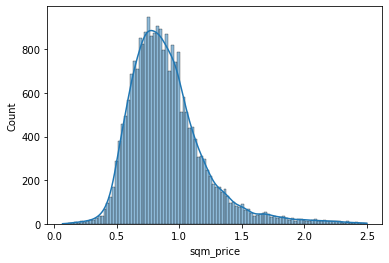

In [33]:
sns.histplot(all_apt_cleaned['sqm_price'], kde = True)

<AxesSubplot:xlabel='price_huf', ylabel='Count'>

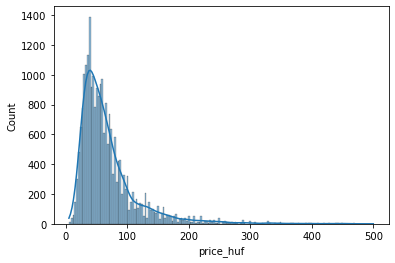

In [34]:
sns.histplot(all_apt_cleaned['price_huf'], kde = True)

<AxesSubplot:xlabel='base_area', ylabel='price_huf'>

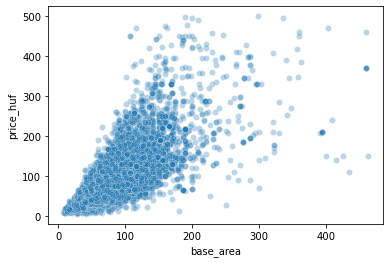

In [35]:
sns.scatterplot(data = all_apt_cleaned,
                x='base_area',
                y='price_huf',
                alpha = 0.3)

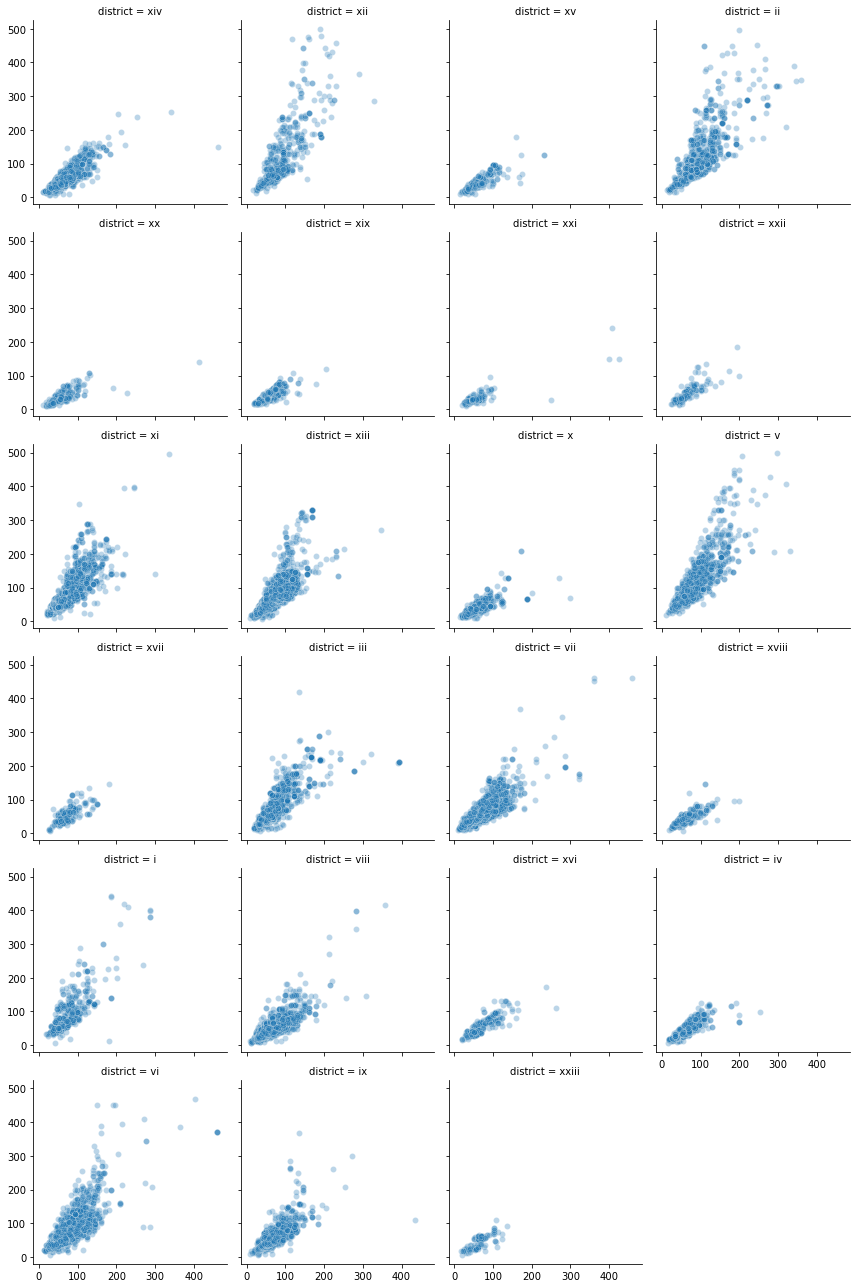

In [36]:
g = sns.FacetGrid(all_apt_cleaned, col="district", margin_titles=True, col_wrap=4)
g.map_dataframe(sns.scatterplot, x="base_area", y="price_huf", alpha = 0.3)

## The data contains similar apartments, this is how ingatlan.com tries to prevent scraping

(I already handled this in the data manipulation part)

In [37]:
madarasz_apts = all_apt_cleaned[all_apt_cleaned['adresses'].str.contains('Madarász', regex=True)]
madarasz_apts = madarasz_apts.sort_values('price_huf', ascending=False)
madarasz_apts

,adresses,price_huf,base_area,balcony_size,area_wiht_balcony_sqm,sqm_price,quality,year_build,floor,max_floor,elevator,indoor_height,heating,for_handicap,bathroom_and_toilet,facing,view,garden,top_floor,parking,parking_place_price,apt_type,energy_label,link,download_time,panelprogram,webpage_all,district,full_room_number,half_room_number,extended_address,lat,lng,postcode,korforgalom_distance,westend_distance,deakter_distance,varosloget_distance,puskasstadion_distance,boraroster_distance,moricz_distance,mammut_distance,lat_jitter,lng_jitter,x,y
13854,"Madarász Viktor utca, XIII. kerület",49.9,58.0,4.0,60.0,0.831667,felújított,nincsmegadva,6,10,van,3mnélalacsonyabb,házközpontiegyediméréssel,igen,különhelyiségben,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,utcaközterületfizetősövezet,nincsmegadva,panel-lakas,nincsmegadva,https://ingatlan.com/xiii-ker/elado+lakas/pane...,2021.12.21 04:50:16,nincsmegadva,https://ingatlan.com/xiii-ker/elado+lakas/pane...,xiii,1,2,"Madarász Viktor utca, XIII. kerület, Budapest...",47.54239,19.073059,1139.0,5500.0,3700.0,5200.0,3200.0,5100.0,6900.0,7800.0,5100.0,47.542100,19.073058,2.123203e+06,6.031012e+06
13853,"Madarász Viktor utca, XIII. kerület",41.9,58.0,4.0,60.0,0.698333,felújított,1950és1980között,9,10,van,3mnélalacsonyabb,távfűtésegyediméréssel,nincsmegadva,különhelyiségben,délkelet,panorámás,nincsmegadva,nemtetőtéri,utcaközterületfizetősövezet,nincsmegadva,panel-lakas,nincsmegadva,https://ingatlan.com/xiii-ker/elado+lakas/pane...,2021.12.21 16:06:03,nincsmegadva,https://ingatlan.com/xiii-ker/elado+lakas/pane...,xiii,1,2,"Madarász Viktor utca, XIII. kerület, Budapest...",47.54239,19.073059,1139.0,5500.0,3700.0,5200.0,3200.0,5100.0,6900.0,7800.0,5100.0,47.542275,19.072884,2.123184e+06,6.031041e+06
13852,"Madarász Viktor utca, XIII. kerület",38.0,71.0,6.0,74.0,0.513514,felújítandó,1950és1980között,9,10,van,nincsmegadva,távfűtés,nem,különhelyiségben,északnyugat,panorámás,nem,nemtetőtéri,utcaközterületfizetősövezet,nincsmegadva,panel-lakas,nincsmegadva,https://ingatlan.com/xiii-ker/elado+lakas/pane...,2021.12.21 16:19:08,nincsmegadva,https://ingatlan.com/xiii-ker/elado+lakas/pane...,xiii,2,1,"Madarász Viktor utca, XIII. kerület, Budapest...",47.54239,19.073059,1139.0,5500.0,3700.0,5200.0,3200.0,5100.0,6900.0,7800.0,5100.0,47.541722,19.073160,2.123214e+06,6.030950e+06
13851,"Madarász Viktor utca, XIII. kerület",34.0,60.0,0.0,60.0,0.566667,felújítandó,1950és1980között,földszint,3,nincs,3mnélalacsonyabb,távfűtés,nem,különhelyiségben,nincsmegadva,nincsmegadva,nincsmegadva,nemtetőtéri,utcaközterületfizetősövezet,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xiii-ker/elado+lakas/tegl...,2021.12.22 05:49:46,nincsmegadva,https://ingatlan.com/xiii-ker/elado+lakas/tegl...,xiii,2,0,"Madarász Viktor utca, XIII. kerület, Budapest...",47.54239,19.073059,1139.0,5500.0,3700.0,5200.0,3200.0,5100.0,6900.0,7800.0,5100.0,47.542259,19.073000,2.123197e+06,6.031038e+06
13850,"Madarász Viktor utca, XIII. kerület",33.9,50.0,4.0,52.0,0.651923,jóállapotú,1950és1980között,4,5,nincs,3mnélalacsonyabb,gázkonvektor,nem,nincsmegadva,délnyugat,panorámás,nem,nincsmegadva,utcaközterületfizetősövezet,nincsmegadva,csuszozsalus-lakas,nincsmegadva,https://ingatlan.com/xiii-ker/elado+lakas/csus...,2021.12.22 02:15:15,nincsmegadva,https://ingatlan.com/xiii-ker/elado+lakas/csus...,xiii,2,0,"Madarász Viktor utca, XIII. kerület, Budapest...",47.54239,19.073059,1139.0,5500.0,3700.0,5200.0,3200.0,5100.0,6900.0,7800.0,5100.0,47.542629,19.073032,2.123200e+06,6.031099e+06
13849,"Madarász Viktor utca, XIII. kerület",14.0,58.0,5.0,60.5,0.231405,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,panel-lakas,nincsmegadva,https://ingatlan.com/xiii-ker/elado+lakas/pane...,2021.12.22 04:31:33,nincsmegadva,https://ingatlan.com/xiii-ker/elado+lakas/pane...,xiii,1,2,"Madarász Viktor ut

## Fix variables that we want to use for modeling

In [38]:
cols_we_want_to_keep = ['price_huf', 'sqm_price', 'base_area', 'balcony_size', 'area_wiht_balcony_sqm', 'full_room_number',
                        'half_room_number', 'district', 'lat', 'lng', 'apt_type', 'quality', 'year_build',
                        'floor', 'max_floor', 'top_floor','bathroom_and_toilet', 'indoor_height', 'view', 'facing',
                        #'heating',
                        'garden', 'elevator', 'for_handicap',
                        #'parking',
                         'korforgalom_distance', 'westend_distance', 'deakter_distance', 'varosloget_distance',
                        'puskasstadion_distance', 'boraroster_distance', 'moricz_distance', 'mammut_distance']

modeling_data_base = all_apt_cleaned[cols_we_want_to_keep]
modeling_data_base

,price_huf,sqm_price,base_area,balcony_size,area_wiht_balcony_sqm,full_room_number,half_room_number,district,lat,lng,apt_type,quality,year_build,floor,max_floor,top_floor,bathroom_and_toilet,indoor_height,view,facing,garden,elevator,for_handicap,korforgalom_distance,westend_distance,deakter_distance,varosloget_distance,puskasstadion_distance,boraroster_distance,moricz_distance,mammut_distance
0,42.0,1.000000,42.0,0.0,42.0,1,1,xiv,NaN,NaN,tegla-epitesu-lakas,felújított,1950előtt,félemelet,3,nincsmegadva,egyhelyiségben,3mnélmagasabb,kertrenéz,északnyugat,nincsmegadva,nincs,nincsmegadva,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,41.2,0.735714,56.0,0.0,56.0,2,0,xiv,47.507331,19.089881,tegla-epitesu-lakas,jóállapotú,1950előtt,szuterén,földszintes,nemtetőtéri,különésegybenis,3mnélalacsonyabb,kertrenéz,délkelet,nincsmegadva,nincs,nem,3900.0,2500.0,2900.0,900.0,1300.0,3500.0,5100.0,4800.0
2,49.9,0.804839,62.0,0.0,62.0,2,0,xiv,47.506101,19.087937,tegla-epitesu-lakas,felújítandó,1950előtt,2,3,nincsmegadva,egyhelyiségben,3mnélmagasabb,udvari,délkelet,nem,nincsmegadva,nincsmegadva,3700.0,2400.0,2700.0,1000.0,1400.0,3300.0,4900.0,4700.0
3,30.9,0.735714,42.0,0.0,42.0,1,0,xiv,47.507331,19.089881,tegla-epitesu-lakas,felújítandó,1950előtt,1,6,nincsmegadva,egyhelyiségben,3mnélmagasabb,utcai,északnyugat,nincsmegadva,van,nem,3900.0,2500.0,2900.0,900.0,1300.0,3500.0,5100.0,4800.0
4,45.0,0.671642,67.0,0.0,67.0,2,0,xiv,47.507331,19.089881,tegla-epitesu-lakas,jóállapotú,1950előtt,félemelet,4,nincsmegadva,nincsmegadva,3mnélmagasabb,kertrenéz,délkelet,nem,van,nincsmegadva,3900.0,2500.0,2900.0,900.0,1300.0,3500.0,5100.0,4800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23376,58.6,0.791892,62.0,24.0,74.0,1,2,xvii,47.470670,19.225553,tegla-epitesu-lakas,jóállapotú,nincsmegadva,földszint,nincsmegadva,nemtetőtéri,különhelyiségben,3mnélalacsonyabb,nincsmegadva,dél,igen,nincsmegadva,nincsmegadva,14300.0,13500.0,13200.0,11700.0,9700.0,12000.0,13900.0,15600.0
23377,18.9,0.572727,33.0,0.0,33.0,1,0,xx,47.445107,19.101489,tegla-epitesu-lakas,jóállapotú,1950előtt,1,2,legfelsőemeletnemtetőtéri,egyhelyiségben,3mnélalacsonyabb,utcai,északkelet,nem,nincs,nem,7500.0,8100.0,6800.0,7900.0,6300.0,4700.0,5700.0,9100.0
23378,19.9,0.537838,37.0,0.0,37.0,1,0,xx,47.445107,19.101489,tegla-epitesu-lakas,jóállapotú,nincsmegadva,nincsmegadva,földszintes,nincsmegadva,egyhelyiségben,nincsmegadva,udvari,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,7500.0,8100.0,6800.0,7900.0,6300.0,4700.0,5700.0,9100.0
23379,19.9,0.423404,37.0,20.0,47.0,1,0,xx,47.445107,19.101489,tegla-epitesu-lakas,felújított,nincsmegadva,földszint,földszintes,nemtetőtéri,egyhelyiségben,3mnélalacsonyabb,kertrenéz,nincsmegadva,igen,nincs,igen,7500.0,8100.0,6800.0,7900.0,6300.0,4700.0,5700.0,9100.0


In [39]:
def fixing_variables_for_modeling(data = modeling_data_base):
    
    warnings.filterwarnings('ignore')
    
    print(len(data))
    
    #drop lat lng with nan values
    cleand_data  = data.dropna(subset=['lat', 'lng'])
    print(len(cleand_data))
    
    #fix year built
    cleand_data['year_build'] = cleand_data['year_build'].replace(['2001és2010között'],'2001')
    cleand_data['year_build'] = cleand_data['year_build'].replace(['1950előtt'],'1900')
    cleand_data['year_build'] = cleand_data['year_build'].replace(['nincsmegadva'],'0')
    cleand_data['year_build'] = cleand_data['year_build'].replace(['1950és1980között'],'1950')
    cleand_data['year_build'] = cleand_data['year_build'].replace(['1981és2000között'],'1981')
    cleand_data['year_build'] = cleand_data['year_build'].astype(int)
    
    # floor
    cleand_data['floor'] = cleand_data['floor'].replace(['10felett'],'11')
    cleand_data['floor'] = cleand_data['floor'].replace(['nincsmegadva'],'-100')
    cleand_data['floor'] = cleand_data['floor'].replace(['félemelet'],'0.5')
    cleand_data['floor'] = cleand_data['floor'].replace(['földszint'],'0')
    cleand_data['floor'] = cleand_data['floor'].replace(['szuterén'],'-1')
    
    # max floor
    cleand_data['max_floor'] = cleand_data['max_floor'].replace(['többmint10'],'11')
    cleand_data['max_floor'] = cleand_data['max_floor'].replace(['nincsmegadva'],'-1')
    cleand_data['max_floor'] = cleand_data['max_floor'].replace(['földszintes'],'0')
    
    # top floor
    cleand_data['top_floor'] = cleand_data['top_floor'].replace(['beépített'],'nincsmegadva')
    
    # indoor height
    cleand_data['indoor_height'] = cleand_data['indoor_height'].replace(['3mnélalacsonyabb'],'3-')
    cleand_data['indoor_height'] = cleand_data['indoor_height'].replace(['3mnélmagasabb'],'3+')
    
    # parking
    cleand_data['indoor_height'] = cleand_data['indoor_height'].replace(['3mnélmagasabb'],'3+', regex = True)
    
    return(cleand_data)

In [40]:
modeling_data = fixing_variables_for_modeling()

23381
19520


In [41]:
modeling_data

,price_huf,sqm_price,base_area,balcony_size,area_wiht_balcony_sqm,full_room_number,half_room_number,district,lat,lng,apt_type,quality,year_build,floor,max_floor,top_floor,bathroom_and_toilet,indoor_height,view,facing,garden,elevator,for_handicap,korforgalom_distance,westend_distance,deakter_distance,varosloget_distance,puskasstadion_distance,boraroster_distance,moricz_distance,mammut_distance
1,41.2,0.735714,56.0,0.0,56.0,2,0,xiv,47.507331,19.089881,tegla-epitesu-lakas,jóállapotú,1900,-1,0,nemtetőtéri,különésegybenis,3-,kertrenéz,délkelet,nincsmegadva,nincs,nem,3900.0,2500.0,2900.0,900.0,1300.0,3500.0,5100.0,4800.0
2,49.9,0.804839,62.0,0.0,62.0,2,0,xiv,47.506101,19.087937,tegla-epitesu-lakas,felújítandó,1900,2,3,nincsmegadva,egyhelyiségben,3+,udvari,délkelet,nem,nincsmegadva,nincsmegadva,3700.0,2400.0,2700.0,1000.0,1400.0,3300.0,4900.0,4700.0
3,30.9,0.735714,42.0,0.0,42.0,1,0,xiv,47.507331,19.089881,tegla-epitesu-lakas,felújítandó,1900,1,6,nincsmegadva,egyhelyiségben,3+,utcai,északnyugat,nincsmegadva,van,nem,3900.0,2500.0,2900.0,900.0,1300.0,3500.0,5100.0,4800.0
4,45.0,0.671642,67.0,0.0,67.0,2,0,xiv,47.507331,19.089881,tegla-epitesu-lakas,jóállapotú,1900,0.5,4,nincsmegadva,nincsmegadva,3+,kertrenéz,délkelet,nem,van,nincsmegadva,3900.0,2500.0,2900.0,900.0,1300.0,3500.0,5100.0,4800.0
5,49.9,0.831667,60.0,0.0,60.0,2,0,xiv,47.507331,19.089881,tegla-epitesu-lakas,felújítandó,1900,2,3,nincsmegadva,egyhelyiségben,3+,nincsmegadva,északnyugat,nincsmegadva,nincs,nem,3900.0,2500.0,2900.0,900.0,1300.0,3500.0,5100.0,4800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23376,58.6,0.791892,62.0,24.0,74.0,1,2,xvii,47.470670,19.225553,tegla-epitesu-lakas,jóállapotú,0,0,-1,nemtetőtéri,különhelyiségben,3-,nincsmegadva,dél,igen,nincsmegadva,nincsmegadva,14300.0,13500.0,13200.0,11700.0,9700.0,12000.0,13900.0,15600.0
23377,18.9,0.572727,33.0,0.0,33.0,1,0,xx,47.445107,19.101489,tegla-epitesu-lakas,jóállapotú,1900,1,2,legfelsőemeletnemtetőtéri,egyhelyiségben,3-,utcai,északkelet,nem,nincs,nem,7500.0,8100.0,6800.0,7900.0,6300.0,4700.0,5700.0,9100.0
23378,19.9,0.537838,37.0,0.0,37.0,1,0,xx,47.445107,19.101489,tegla-epitesu-lakas,jóállapotú,0,-100,0,nincsmegadva,egyhelyiségben,nincsmegadva,udvari,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,7500.0,8100.0,6800.0,7900.0,6300.0,4700.0,5700.0,9100.0
23379,19.9,0.423404,37.0,20.0,47.0,1,0,xx,47.445107,19.101489,tegla-epitesu-lakas,felújított,0,0,0,nemtetőtéri,egyhelyiségben,3-,kertrenéz,nincsmegadva,igen,nincs,igen,7500.0,8100.0,6800.0,7900.0,6300.0,4700.0,5700.0,9100.0


In [42]:
modeling_data.describe()

,price_huf,sqm_price,base_area,balcony_size,area_wiht_balcony_sqm,full_room_number,half_room_number,lat,lng,year_build,korforgalom_distance,westend_distance,deakter_distance,varosloget_distance,puskasstadion_distance,boraroster_distance,moricz_distance,mammut_distance
count,19520.000000,19520.000000,19520.000000,19520.000000,19520.000000,19520.000000,19520.000000,19520.000000,19520.000000,19520.000000,19520.000000,19520.000000,19520.000000,19520.000000,19520.000000,19520.000000,19520.000000,19520.000000
mean,67.258234,0.901335,69.769672,6.436014,72.987679,2.341547,0.277818,47.502425,19.075052,1498.162859,5084.180328,4639.692623,4662.054303,4771.557377,5219.667008,5127.781762,5873.780738,5663.012295
std,49.554920,0.299466,35.832646,19.423288,39.455042,1.183114,0.583707,0.037725,0.044861,829.756298,3203.227877,3211.167100,3162.969560,2928.056430,2630.867966,3036.636144,3203.605679,3313.678613
min,5.000000,0.110400,8.000000,0.000000,8.000000,0.000000,0.000000,47.378951,18.937419,0.000000,0.000000,100.000000,0.000000,500.000000,100.000000,100.000000,0.000000,0.000000
25%,37.500000,0.700000,47.000000,0.000000,49.000000,2.000000,0.000000,47.480965,19.048836,1900.000000,2600.000000,2100.000000,2000.000000,2400.000000,3100.000000,2700.000000,3500.000000,3300.000000
50%,54.500000,0.855251,63.000000,0.000000,65.000000,2.000000,0.000000,47.503644,19.069843,1900.000000,4200.000000,4000.000000,4100.000000,4100.000000,4800.000000,4500.000000,5000.000000,4800.000000
75%,79.500000,1.035439,84.000000,6.000000,87.500000,3.000000,0.000000,47.523601,19.094379,2001.000000,7000.000000,6600.000000,6900.000000,6400.000000,6900.000000,7000.000000,8100.000000,7700.000000
max,500.000000,2.500000,462.000000,563.000000,627.000000,20.000000,11.000000,47.609315,19.314670,2025.000000,21100.000000,20300.000000,20100.000000,18400.000000,17400.000000,18800.000000,20700.000000,22400.000000


In [43]:
modeling_data.describe(include=["object"])

,district,apt_type,quality,floor,max_floor,top_floor,bathroom_and_toilet,indoor_height,view,facing,garden,elevator,for_handicap
count,19520,19520,19520,19520,19520,19520,19520,19520,19520,19520,19520,19520,19520
unique,23,3,8,15,12,6,4,3,5,9,3,3,3
top,xiii,tegla-epitesu-lakas,felújított,1,-1,nemtetőtéri,nincsmegadva,3-,utcai,nincsmegadva,nincsmegadva,van,nincsmegadva
freq,2464,17614,4830,3946,5393,9628,6673,7041,6918,7036,11827,10071,12495


In [44]:
categorical_vars = modeling_data.describe(include=["object"]).columns
continuous_vars = modeling_data.describe().columns

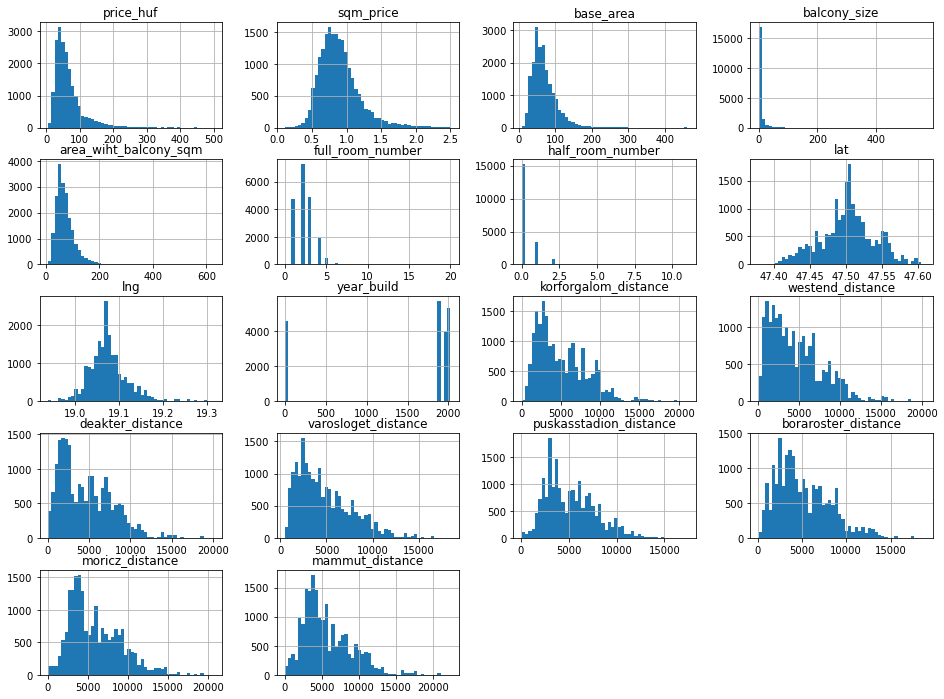

In [45]:
plot = modeling_data.hist(column=continuous_vars, figsize = (16, 12), bins = 50)

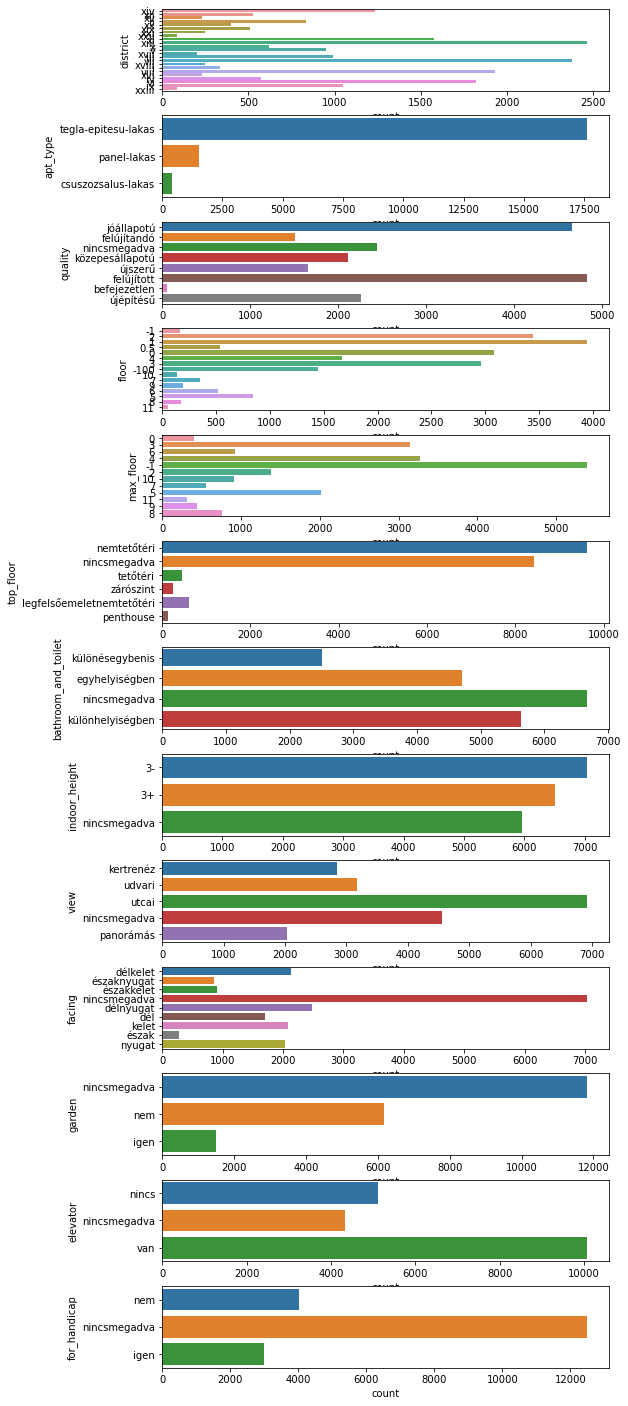

In [46]:
fig, axes = plt.subplots(13, 1, figsize=(8, 25))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=0.3)

for i, ax in enumerate(axes.ravel()):
    plot = sns.countplot(y = categorical_vars[i], data=modeling_data, ax=ax)

## Train and Test split

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
model_data_dummies = pd.get_dummies(modeling_data, columns = categorical_vars, drop_first=False)
model_data_dummies.columns

Index(['price_huf', 'sqm_price', 'base_area', 'balcony_size',
       'area_wiht_balcony_sqm', 'full_room_number', 'half_room_number', 'lat',
       'lng', 'year_build',
       ...
       'facing_északnyugat', 'garden_igen', 'garden_nem',
       'garden_nincsmegadva', 'elevator_nincs', 'elevator_nincsmegadva',
       'elevator_van', 'for_handicap_igen', 'for_handicap_nem',
       'for_handicap_nincsmegadva'],
      dtype='object', length=115)

In [49]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(model_data_dummies.drop(['price_huf', 'sqm_price'], axis=1),
                                                    model_data_dummies['sqm_price'],
                                                    test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15616, 113) (3904, 113) (15616,) (3904,)


In [50]:
X_train

,base_area,balcony_size,area_wiht_balcony_sqm,full_room_number,half_room_number,lat,lng,year_build,korforgalom_distance,westend_distance,deakter_distance,varosloget_distance,puskasstadion_distance,boraroster_distance,moricz_distance,mammut_distance,district_i,district_ii,district_iii,district_iv,district_ix,district_v,district_vi,district_vii,district_viii,district_x,district_xi,district_xii,district_xiii,district_xiv,district_xix,district_xv,district_xvi,district_xvii,district_xviii,district_xx,district_xxi,district_xxii,district_xxiii,apt_type_csuszozsalus-lakas,apt_type_panel-lakas,apt_type_tegla-epitesu-lakas,quality_befejezetlen,quality_felújítandó,quality_felújított,quality_jóállapotú,quality_közepesállapotú,quality_nincsmegadva,quality_újszerű,quality_újépítésű,floor_-1,floor_-100,floor_0,floor_0.5,floor_1,floor_10,floor_11,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_9,max_floor_-1,max_floor_0,max_floor_10,max_floor_11,max_floor_2,max_floor_3,max_floor_4,max_floor_5,max_floor_6,max_floor_7,max_floor_8,max_floor_9,top_floor_legfelsőemeletnemtetőtéri,top_floor_nemtetőtéri,top_floor_nincsmegadva,top_floor_penthouse,top_floor_tetőtéri,top_floor_zárószint,bathroom_and_toilet_egyhelyiségben,bathroom_and_toilet_különhelyiségben,bathroom_and_toilet_különésegybenis,bathroom_and_toilet_nincsmegadva,indoor_height_3+,indoor_height_3-,indoor_height_nincsmegadva,view_kertrenéz,view_nincsmegadva,view_panorámás,view_udvari,view_utcai,facing_dél,facing_délkelet,facing_délnyugat,facing_kelet,facing_nincsmegadva,facing_nyugat,facing_észak,facing_északkelet,facing_északnyugat,garden_igen,garden_nem,garden_nincsmegadva,elevator_nincs,elevator_nincsmegadva,elevator_van,for_handicap_igen,for_handicap_nem,for_handicap_nincsmegadva
16908,69.0,0.0,69.0,3,0,47.500466,19.078719,1900,2900.0,2000.0,1900.0,1700.0,2000.0,2400.0,4000.0,4100.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0
17060,63.0,7.0,66.5,3,0,47.557242,19.120154,0,8900.0,7000.0,8300.0,5400.0,6200.0,9500.0,10900.0,8900.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0
14983,134.0,2.0,135.0,3,0,47.502677,19.061686,0,1700.0,1000.0,800.0,2200.0,3300.0,2500.0,3400.0,2800.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
7169,62.0,9.0,66.5,2,0,47.477772,19.086329,2023,4100.0,4300.0,3300.0,4100.0,3100.0,1500.0,3400.0,5700.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1
5191,57.0,6.0,60.0,1,2,47.549295,19.115562,2001,8000.0,6100.0,7400.0,4500.0,5300.0,8500.0,10000.0,8100.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20192,84.0,4.0,86.0,4,0,47.480674,19.097577,1900,4700.0,4600.0,3800.0,3900.0,2400.0,2300.0,4300.0,6200.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0

## Train a RF model

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [52]:
# Create the parameter grid based on the results of random search 
param_grid = {
    #'bootstrap': [True, False],
    'max_depth': [50],
    'max_features': [75, 100],
    'min_samples_leaf': [5, 10, 20],
    'min_samples_split': [10],
    'n_estimators': [300]
}

param_grid = {
    #'bootstrap': [True, False],
    'max_depth': [40],
    'max_features': [100],
    'min_samples_leaf': [5],
    'min_samples_split': [10],
    'n_estimators': [500]
}

# Instantiate the grid search model
rf_cv = GridSearchCV(estimator = RandomForestRegressor(),
                     param_grid = param_grid,
                     cv = 5,
                     n_jobs = -1,
                     verbose = 10)

In [53]:
# Fit the grid search to the data
rf_model = rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [54]:
print(rf_cv.best_params_)

{'max_depth': 40, 'max_features': 100, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}


In [55]:
rf_final = rf_cv.best_estimator_
rf_final

RandomForestRegressor(max_depth=40, max_features=100, min_samples_leaf=5,
                      min_samples_split=10, n_estimators=500)

In [56]:
#rf_final_cv = model_selection.cross_val_score(rf_cv,
#                                              X_train, y_train,
#                                              cv=5,
#                                              scoring='neg_root_mean_squared_error')
#
#print(rf_final_cv)
#print('------------------------------------')
#print("Mean RMSE using the RF model on the train data (with 5 CV): ", rf_final_cv.mean().round(3))

In [57]:
rf_final_train_pred = rf_model.predict(X_train)
rf_final_test_pred = rf_model.predict(X_test)

In [58]:
rf_final_test_pred

array([0.80715853, 0.85388156, 0.983308  , ..., 0.85843089, 1.01636873,
       0.92937213])

In [59]:
X_test['test_pred_rf'] = rf_final_test_pred
X_test['y'] = y_test

In [60]:
def calculate_eval_metrics(data = X_test, y_true = 'y', y_pred = 'test_pred_rf'):
    
    RMSE = (((data[y_true] - data[y_pred]) ** 2).mean() ** .5)
    RMSE = round(RMSE, 4)
    print("RMSE:", RMSE)
    
    MAE = abs(data[y_true] - data[y_pred]).mean()
    MAE = round(MAE, 4)
    print("MAE:", MAE)
    
    return(RMSE, MAE)

In [61]:
RMSE_rf, MAE_rf = calculate_eval_metrics()

RMSE: 0.1727
MAE: 0.1133


In [62]:
def plot_RMSE_scatter(data = X_test, y_true = 'y', y_pred = 'test_pred_rf'):
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(data[y_true],data[y_pred])
    RMSE_plot = sns.regplot(data = data, x=y_true, y=y_pred, fit_reg=True,
                            scatter_kws={'alpha':0.1,},
                            line_kws = {'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    RMSE_plot = RMSE_plot.legend()
    
    return(RMSE_plot)

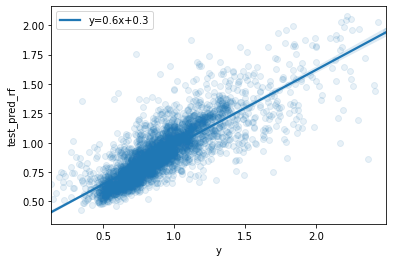

In [63]:
plot_RMSE_scatter()

In [64]:
def plot_RMSE_hist(data = X_test, y_true = 'y', y_pred = 'test_pred_rf'):
    
    RMSE_error_hist_plot = sns.histplot(data[y_pred] - data[y_true], kde = True)
    
    return(RMSE_error_hist_plot)

<AxesSubplot:ylabel='Count'>

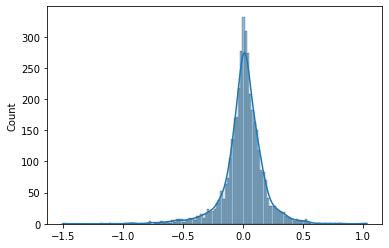

In [65]:
plot_RMSE_hist()

In [66]:
X_test

,base_area,balcony_size,area_wiht_balcony_sqm,full_room_number,half_room_number,lat,lng,year_build,korforgalom_distance,westend_distance,deakter_distance,varosloget_distance,puskasstadion_distance,boraroster_distance,moricz_distance,mammut_distance,district_i,district_ii,district_iii,district_iv,district_ix,district_v,district_vi,district_vii,district_viii,district_x,district_xi,district_xii,district_xiii,district_xiv,district_xix,district_xv,district_xvi,district_xvii,district_xviii,district_xx,district_xxi,district_xxii,district_xxiii,apt_type_csuszozsalus-lakas,apt_type_panel-lakas,apt_type_tegla-epitesu-lakas,quality_befejezetlen,quality_felújítandó,quality_felújított,quality_jóállapotú,quality_közepesállapotú,quality_nincsmegadva,quality_újszerű,quality_újépítésű,floor_-1,floor_-100,floor_0,floor_0.5,floor_1,floor_10,floor_11,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_9,max_floor_-1,max_floor_0,max_floor_10,max_floor_11,max_floor_2,max_floor_3,max_floor_4,max_floor_5,max_floor_6,max_floor_7,max_floor_8,max_floor_9,top_floor_legfelsőemeletnemtetőtéri,top_floor_nemtetőtéri,top_floor_nincsmegadva,top_floor_penthouse,top_floor_tetőtéri,top_floor_zárószint,bathroom_and_toilet_egyhelyiségben,bathroom_and_toilet_különhelyiségben,bathroom_and_toilet_különésegybenis,bathroom_and_toilet_nincsmegadva,indoor_height_3+,indoor_height_3-,indoor_height_nincsmegadva,view_kertrenéz,view_nincsmegadva,view_panorámás,view_udvari,view_utcai,facing_dél,facing_délkelet,facing_délnyugat,facing_kelet,facing_nincsmegadva,facing_nyugat,facing_észak,facing_északkelet,facing_északnyugat,garden_igen,garden_nem,garden_nincsmegadva,elevator_nincs,elevator_nincsmegadva,elevator_van,for_handicap_igen,for_handicap_nem,for_handicap_nincsmegadva,test_pred_rf,y
22594,72.0,0.0,72.0,2,1,47.546405,19.026362,1900,5500.0,4500.0,5800.0,5600.0,7700.0,8000.0,8000.0,4100.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0.807159,0.831944
19352,122.0,0.0,122.0,3,0,47.511064,19.032309,1900,1600.0,1800.0,2200.0,3900.0,5600.0,4300.0,4000.0,500.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0.853882,0.736885
1083,52.0,6.0,55.0,2,0,47.550222,19.089510,2021,6900.0,5000.0,6500.0,4000.0,5500.0,8000.0,9100.0,6600.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0.983308,0.919636
10207,55.0,0.0,55.0,2,0,47.499904,19.059540,2001,1500.0,1300.0,500.0,2500.0,3500.0,2300.0,3100.0,2700.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1.219100,1.309091
10327,80.0,0.0,80.0,3,0,47.503873,19.066565,1900,2100.0,1100.0,1200.0,1800.0,2900.0,2600.0,3700.0,3100.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0.870293,0.561250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6591,100.0,22.0,111.0,4,1,47.503921,19.086419,2001,3500.0,2400.0,2500.0,1200.0,1400.0,3000.0,4700.0,4600.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,

## xgBoost model

In [67]:
import xgboost as xgb

In [68]:
try:
    X_test = X_test.drop(['test_pred_rf'], axis=1)
except:
    print("nothing 1")

try:
    X_test = X_test.drop(['test_pred_xgb'], axis=1)
except:
    print('nothing 2')

try:
    X_test = X_test.drop(['y'], axis=1)
except:
    print('nothing 3')

nothing 2


In [69]:
xgb_grid = {'nthread':[-1], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [5, 10],
              'min_child_weight': [11, 18],
              'subsample': [0.8, 0.9],
              'colsample_bytree': [0.7],
              'n_estimators': [500], #number of trees, change it to 1000 for better results
              'seed': [42]}


xgb_cv = GridSearchCV(estimator = xgb.XGBRegressor(),
                      param_grid = xgb_grid,
                      n_jobs=-1,
                      cv=5,
                      verbose = 10)

In [70]:
xgb_model = xgb_cv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [71]:
print(xgb_model.best_params_)

{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 11, 'n_estimators': 500, 'nthread': -1, 'objective': 'reg:squarederror', 'seed': 42, 'subsample': 0.8}


In [72]:
xgb_final = xgb_cv.best_estimator_
xgb_final

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=11, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=4, nthread=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [73]:
#xgb_final_cv = model_selection.cross_val_score(xgb_cv,
#                                              X_train, y_train,
#                                              cv=5,
#                                              scoring='neg_root_mean_squared_error')
#
#print(xgb_final_cv)
#print('------------------------------------')
#print("Mean RMSE using the RF model on the train data (with 5 CV): ", rf_final_cv.mean().round(3))

In [74]:
xgb_final_train_pred = xgb_model.predict(X_train)
xgb_final_test_pred = xgb_model.predict(X_test)

In [75]:
xgb_final_test_pred

array([0.8170231 , 0.78798276, 0.9779609 , ..., 0.9306613 , 1.0436945 ,
       0.8688012 ], dtype=float32)

In [76]:
X_test['test_pred_xgb'] = xgb_final_test_pred
X_test['y'] = y_test

In [77]:
X_test

,base_area,balcony_size,area_wiht_balcony_sqm,full_room_number,half_room_number,lat,lng,year_build,korforgalom_distance,westend_distance,deakter_distance,varosloget_distance,puskasstadion_distance,boraroster_distance,moricz_distance,mammut_distance,district_i,district_ii,district_iii,district_iv,district_ix,district_v,district_vi,district_vii,district_viii,district_x,district_xi,district_xii,district_xiii,district_xiv,district_xix,district_xv,district_xvi,district_xvii,district_xviii,district_xx,district_xxi,district_xxii,district_xxiii,apt_type_csuszozsalus-lakas,apt_type_panel-lakas,apt_type_tegla-epitesu-lakas,quality_befejezetlen,quality_felújítandó,quality_felújított,quality_jóállapotú,quality_közepesállapotú,quality_nincsmegadva,quality_újszerű,quality_újépítésű,floor_-1,floor_-100,floor_0,floor_0.5,floor_1,floor_10,floor_11,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_9,max_floor_-1,max_floor_0,max_floor_10,max_floor_11,max_floor_2,max_floor_3,max_floor_4,max_floor_5,max_floor_6,max_floor_7,max_floor_8,max_floor_9,top_floor_legfelsőemeletnemtetőtéri,top_floor_nemtetőtéri,top_floor_nincsmegadva,top_floor_penthouse,top_floor_tetőtéri,top_floor_zárószint,bathroom_and_toilet_egyhelyiségben,bathroom_and_toilet_különhelyiségben,bathroom_and_toilet_különésegybenis,bathroom_and_toilet_nincsmegadva,indoor_height_3+,indoor_height_3-,indoor_height_nincsmegadva,view_kertrenéz,view_nincsmegadva,view_panorámás,view_udvari,view_utcai,facing_dél,facing_délkelet,facing_délnyugat,facing_kelet,facing_nincsmegadva,facing_nyugat,facing_észak,facing_északkelet,facing_északnyugat,garden_igen,garden_nem,garden_nincsmegadva,elevator_nincs,elevator_nincsmegadva,elevator_van,for_handicap_igen,for_handicap_nem,for_handicap_nincsmegadva,test_pred_xgb,y
22594,72.0,0.0,72.0,2,1,47.546405,19.026362,1900,5500.0,4500.0,5800.0,5600.0,7700.0,8000.0,8000.0,4100.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0.817023,0.831944
19352,122.0,0.0,122.0,3,0,47.511064,19.032309,1900,1600.0,1800.0,2200.0,3900.0,5600.0,4300.0,4000.0,500.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0.787983,0.736885
1083,52.0,6.0,55.0,2,0,47.550222,19.089510,2021,6900.0,5000.0,6500.0,4000.0,5500.0,8000.0,9100.0,6600.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0.977961,0.919636
10207,55.0,0.0,55.0,2,0,47.499904,19.059540,2001,1500.0,1300.0,500.0,2500.0,3500.0,2300.0,3100.0,2700.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1.281550,1.309091
10327,80.0,0.0,80.0,3,0,47.503873,19.066565,1900,2100.0,1100.0,1200.0,1800.0,2900.0,2600.0,3700.0,3100.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0.874221,0.561250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6591,100.0,22.0,111.0,4,1,47.503921,19.086419,2001,3500.0,2400.0,2500.0,1200.0,1400.0,3000.0,4700.0,4600.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0

In [78]:
RMSE_xgb, MAE_xgb = calculate_eval_metrics(data = X_test,y_pred ='test_pred_xgb')

RMSE: 0.16
MAE: 0.1052


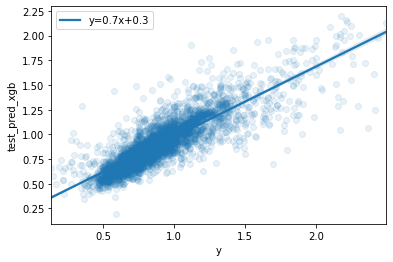

In [80]:
plot_RMSE_scatter(data = X_test,y_pred = 'test_pred_xgb')

<AxesSubplot:ylabel='Count'>

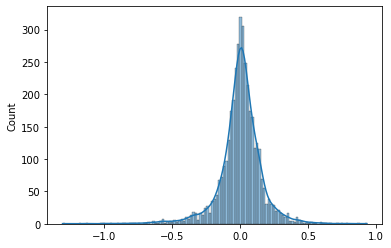

In [81]:
plot_RMSE_hist(data = X_test,  y_pred = 'test_pred_xgb')

## Proba prediction

In [82]:
all_columns = X_test.columns

In [83]:
print("\n".join([str(x) for x in all_columns]))

base_area
balcony_size
area_wiht_balcony_sqm
full_room_number
half_room_number
lat
lng
year_build
korforgalom_distance
westend_distance
deakter_distance
varosloget_distance
puskasstadion_distance
boraroster_distance
moricz_distance
mammut_distance
district_i
district_ii
district_iii
district_iv
district_ix
district_v
district_vi
district_vii
district_viii
district_x
district_xi
district_xii
district_xiii
district_xiv
district_xix
district_xv
district_xvi
district_xvii
district_xviii
district_xx
district_xxi
district_xxii
district_xxiii
apt_type_csuszozsalus-lakas
apt_type_panel-lakas
apt_type_tegla-epitesu-lakas
quality_befejezetlen
quality_felújítandó
quality_felújított
quality_jóállapotú
quality_közepesállapotú
quality_nincsmegadva
quality_újszerű
quality_újépítésű
floor_-1
floor_-100
floor_0
floor_0.5
floor_1
floor_10
floor_11
floor_2
floor_3
floor_4
floor_5
floor_6
floor_7
floor_8
floor_9
max_floor_-1
max_floor_0
max_floor_10
max_floor_11
max_floor_2
max_floor_3
max_floor_4
max_flo

In [84]:
# initialize data of lists.
data = {'Name':['Tom', 'nick', 'krish', 'jack'],
        'Age':[20, 21, 19, 18]}
  
# Create DataFrame
df = pd.DataFrame(data)
  
# Print the output.
df

,Name,Age
0,Tom,20
1,nick,21
2,krish,19
3,jack,18
